In [1]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import DenseNet121
from sklearn.model_selection import train_test_split

In [2]:
x = np.load('/content/drive/MyDrive/NF/resized_images.npy')
y = np.load('/content/drive/MyDrive/NF/labels.npy')

# Perform train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

# Create DenseNet base
input_shape = x_train.shape[1:]  # Assuming x_train is a numpy array of images
input_shape

(128, 128, 3)

In [3]:
print(x_train.shape)
print(x_test.shape)

(2200, 128, 128, 3)
(550, 128, 128, 3)


In [4]:
def create_densenet_base(input_shape):
    # Load DenseNet model without the top layer
    base_model = DenseNet121(include_top=False, input_shape=input_shape)

    # Perform global average pooling
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add a dense layer with 125 sigmoid activated neurons
    x = Dense(125, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

def create_classification_model(base_model, num_classes):
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = True

    # Add a dense layer with softmax activation for classification
    x = Dense(num_classes, activation='softmax')(base_model.output)

    # Create the classification model
    model = Model(inputs=base_model.input, outputs=x)

    return model

base_model = create_densenet_base(input_shape)

num_classes = 5  # Change this to the number of classes in your classification task
classification_model = create_classification_model(base_model, num_classes)

classification_model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 134, 134, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 64, 64, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati

In [5]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
classification_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint("/content/drive/MyDrive/NF/classification_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Train the model
history = classification_model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test), callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/25
69/69 [==============================] - ETA: 0s - loss: 1.1591 - accuracy: 0.5150
Epoch 1: val_loss improved from inf to 3.21052, saving model to /content/drive/MyDrive/NF/classification_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 102s 424ms/step - loss: 1.1591 - accuracy: 0.5150 - val_loss: 3.2105 - val_accuracy: 0.2309 - lr: 0.0010
Epoch 2/25
69/69 [==============================] - ETA: 0s - loss: 0.8227 - accuracy: 0.6500
Epoch 2: val_loss improved from 3.21052 to 2.42106, saving model to /content/drive/MyDrive/NF/classification_model.h5
69/69 [==============================] - 12s 170ms/step - loss: 0.8227 - accuracy: 0.6500 - val_loss: 2.4211 - val_accuracy: 0.4236 - lr: 0.0010
Epoch 3/25
69/69 [==============================] - ETA: 0s - loss: 0.6339 - accuracy: 0.7405
Epoch 3: val_loss improved from 2.42106 to 1.58677, saving model to /content/drive/MyDrive/NF/classification_model.h5
69/69 [==============================] - 12s 169ms/step - loss: 0.6339 - accuracy: 0.7405 - val_loss: 1.5868 - val_accuracy: 0.5800 - lr: 0.0010
Epoch 4/25
69/69 [==============================] - ETA: 0s - loss: 0.5360 - accuracy: 0.7964
Epoch 4: val_loss did not improve from 1.58677

In [6]:
classification_model.load_weights("/content/drive/MyDrive/NF/classification_model.h5")
classification_model.evaluate(x_test, y_test)

18/18 [==============================] - 1s 39ms/step - loss: 0.2395 - accuracy: 0.9200


[0.2395409643650055, 0.9200000166893005]

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming classification_model.predict returns probabilities or predicted classes
y_pred = classification_model.predict(x_test)

# If y_pred contains probabilities, you may want to convert them to classes
# For binary classification:
# y_pred_classes = (y_pred > 0.5).astype(int)

# For multi-class classification with softmax output:
y_pred_classes = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report

# Assuming y_pred_classes are predicted classes

# Generate classification report
report = classification_report(y_test, y_pred_classes, digits=5)

# Print the report
print("Classification Report:")
print(report)


18/18 [==============================] - 2s 35ms/step
Classification Report:
              precision    recall  f1-score   support

           0    0.98077   0.93578   0.95775       109
           1    1.00000   0.98291   0.99138       117
           2    0.86087   0.96117   0.90826       103
           3    0.90196   0.81416   0.85581       113
           4    0.85965   0.90741   0.88288       108

    accuracy                        0.92000       550
   macro avg    0.92065   0.92028   0.91922       550
weighted avg    0.92243   0.92000   0.91999       550



18/18 [==============================] - 3s 30ms/step


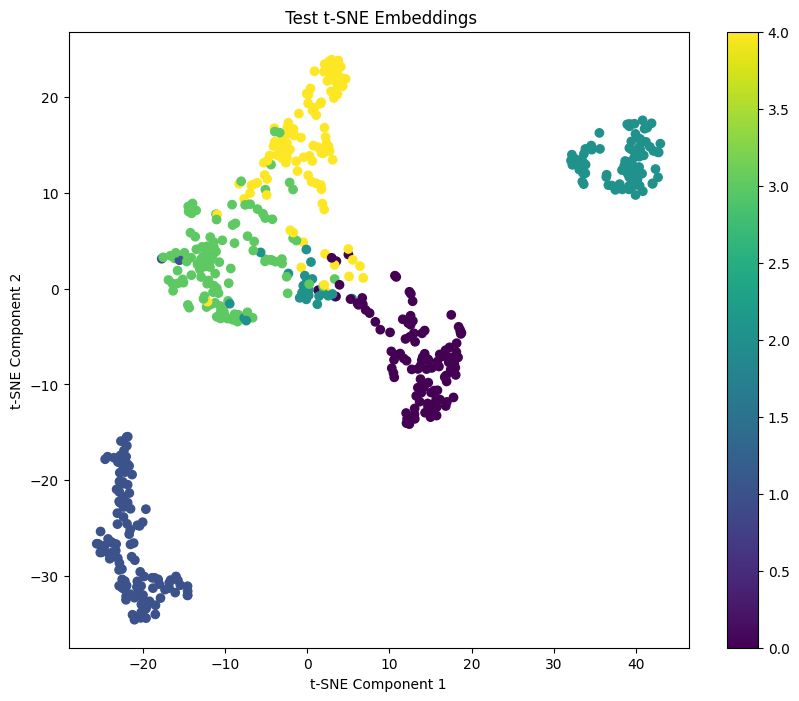

In [8]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_test_embed are the embeddings obtained from the penultimate layer
tsne = TSNE(n_components=2, random_state=42)
x_embed = base_model.predict(x_test)  # Assuming x_test is your test data
x_tsne = tsne.fit_transform(x_embed)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.title(' Test t-SNE Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


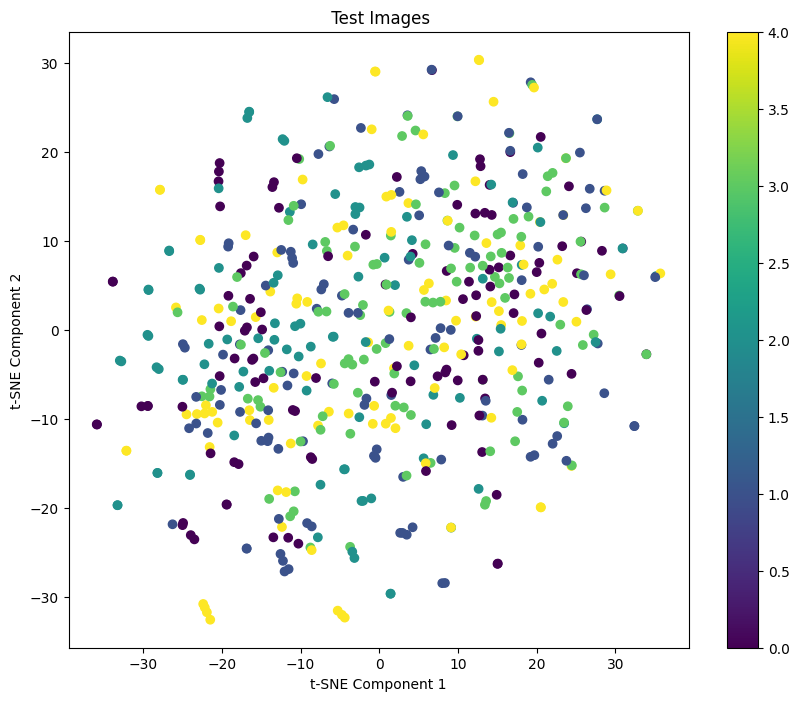

In [9]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_test_embed are the embeddings obtained from the penultimate layer
x_test_flat = x_test.reshape((550, 128*128*3))
tsne = TSNE(n_components=2, random_state=42)
#x_embed = base_model.predict(x_test)  # Assuming x_test is your test data
x_tsne = tsne.fit_transform(x_test_flat)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.title(' Test Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


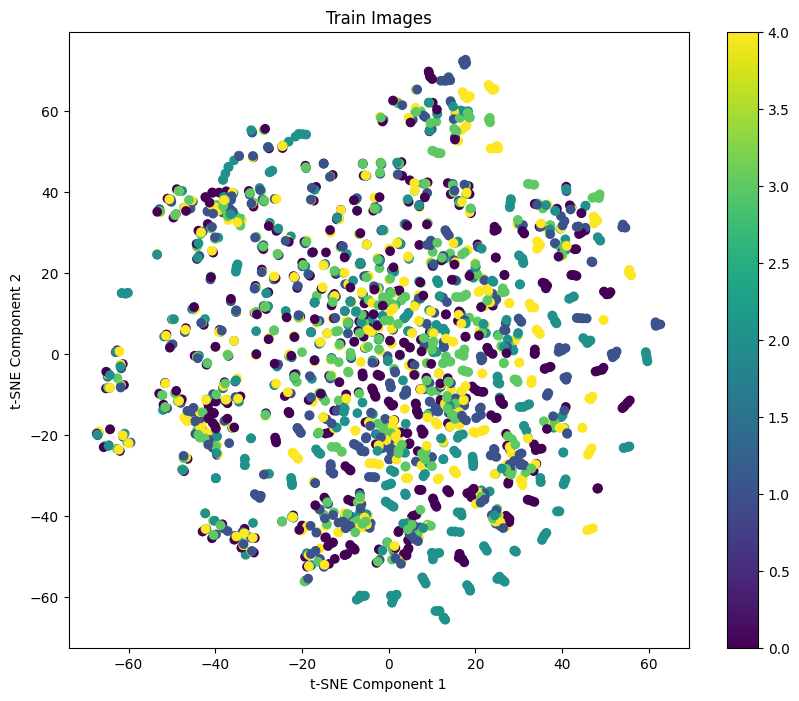

In [10]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_train_embed are the embeddings obtained from the penultimate layer
x_train_flat = x_train.reshape((2200, 128*128*3))
tsne = TSNE(n_components=2, random_state=42)
#x_embed = base_model.predict(x_train)  # Assuming x_train is your train data
x_tsne = tsne.fit_transform(x_train_flat)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title('Train Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


69/69 [==============================] - 2s 28ms/step


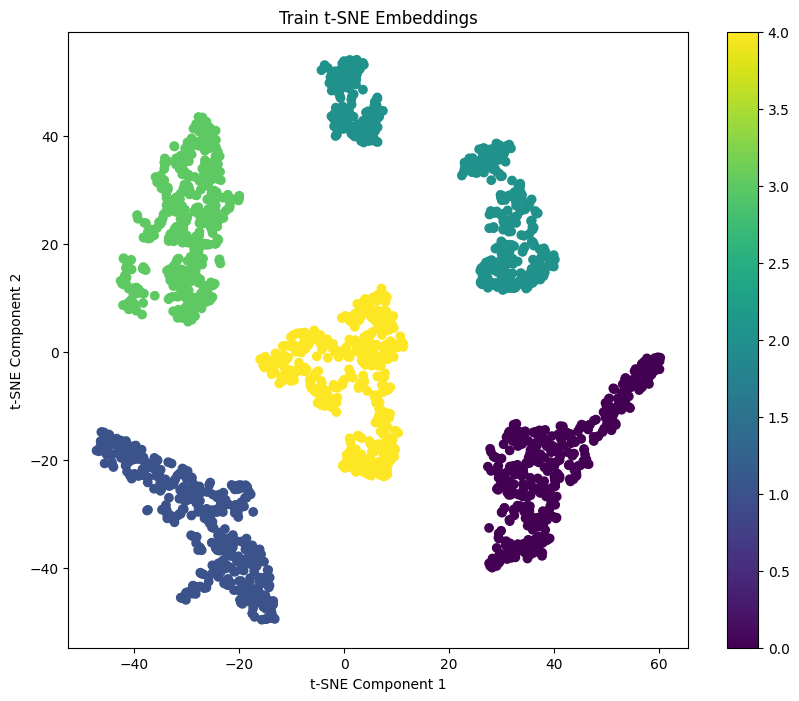

In [11]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_train_embed are the embeddings obtained from the penultimate layer
tsne = TSNE(n_components=2, random_state=42)
x_embed = base_model.predict(x_train)  # Assuming x_train is your train data
x_tsne = tsne.fit_transform(x_embed)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title('Train t-SNE Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


<h1>E-Mixup

In [12]:
xtest_emb = base_model.predict(x_test)
xtrain_emb = base_model.predict(x_train)

69/69 [==============================] - 2s 27ms/step


In [13]:
import keras
y_test_o = keras.utils.to_categorical(y_test)
y_train_o = keras.utils.to_categorical(y_train)
print(y_train_o.shape)
print(y_test_o.shape)

(2200, 5)
(550, 5)


In [14]:
def mixup(xt, yt, mf):
  alp = 0.2
  xaug = []
  yaug = []
  for k in range(0,xt.shape[0]):
    cnt = 0
    for cnt in range(0,mf-1):
      lbd = np.random.beta(alp,alp)
      yks = np.random.randint(xt.shape[0])
      kdash = xt[yks]
      ydash = yt[yks]
      kdash1 = xt[k]
      ydash1 = yt[k]
      xaug1 = kdash1*lbd + kdash*(1-lbd)
      yaug1 = ydash1*lbd + ydash*(1-lbd)
      xaug.append(xaug1)
      yaug.append(yaug1)
  xs2 = np.asarray(xaug)
  ys2 = np.asarray(yaug)
  x1 = np.concatenate((xt,xs2))
  y1 = np.concatenate((yt,ys2))
  return x1,y1

In [15]:
xtrain_emb.shape

(2200, 125)

In [16]:
xtt, ytt = mixup(xtrain_emb,y_train_o,3)
xtt.shape

(6600, 125)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import tensorflow as tf

Classifier_model = Sequential()
#add model layers
Classifier_model.Input = (125,)

Classifier_model.add(Dense(512,activation='relu'))
Classifier_model.add(Dense(512,activation='relu'))

Classifier_model.add(Dense(5, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
Classifier_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(xtt, ytt,epochs=25, validation_data=(xtest_emb, y_test_o))

Epoch 1/25
207/207 [==============================] - 2s 4ms/step - loss: 0.2018 - accuracy: 0.9871 - val_loss: 0.2262 - val_accuracy: 0.9273
Epoch 2/25
207/207 [==============================] - 1s 3ms/step - loss: 0.1610 - accuracy: 0.9902 - val_loss: 0.2457 - val_accuracy: 0.9309
Epoch 3/25
207/207 [==============================] - 1s 3ms/step - loss: 0.1497 - accuracy: 0.9858 - val_loss: 0.2542 - val_accuracy: 0.9255
Epoch 4/25
207/207 [==============================] - 1s 3ms/step - loss: 0.1445 - accuracy: 0.9862 - val_loss: 0.2587 - val_accuracy: 0.9309
Epoch 5/25
207/207 [==============================] - 1s 4ms/step - loss: 0.1420 - accuracy: 0.9874 - val_loss: 0.2535 - val_accuracy: 0.9273
Epoch 6/25
207/207 [==============================] - 1s 5ms/step - loss: 0.1392 - accuracy: 0.9903 - val_loss: 0.2459 - val_accuracy: 0.9273
Epoch 7/25
207/207 [==============================] - 1s 4ms/step - loss: 0.1372 - accuracy: 0.9898 - val_loss: 0.2576 - val_accuracy: 0.9273
Epoch 

In [18]:
Classifier_model.evaluate(xtest_emb, y_test_o)

18/18 [==============================] - 0s 2ms/step - loss: 0.3189 - accuracy: 0.9200


[0.31888970732688904, 0.9200000166893005]

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming Classifier_model.predict returns probabilities or predicted classes
y_pred = Classifier_model.predict(xtest_emb)

# If y_pred contains probabilities, you may want to convert them to classes
# For binary classification:
# y_pred_classes = (y_pred > 0.5).astype(int)
# For multi-class classification with softmax output:
y_pred_classes = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report

# Assuming y_pred_classes are predicted classes

# Generate classification report
report = classification_report(y_test, y_pred_classes, digits=5)

# Print the report
print("Classification Report:")
print(report)



18/18 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0    0.97087   0.91743   0.94340       109
           1    1.00000   0.98291   0.99138       117
           2    0.88991   0.94175   0.91509       103
           3    0.87387   0.85841   0.86607       113
           4    0.86607   0.89815   0.88182       108

    accuracy                        0.92000       550
   macro avg    0.92015   0.91973   0.91955       550
weighted avg    0.92140   0.92000   0.92032       550



E-Stitchup

In [20]:
import numpy as np

def stichup(xt, yt, mf):
    alp = 0.2
    xaug = []
    yaug = []
    for k in range(xt.shape[0]):
        for _ in range(mf-1):  # Renamed loop counter to avoid confusion with loop index
            lbd = np.random.beta(alp, alp)
            yks = np.random.randint(xt.shape[0])
            kdash = xt[yks]  # Accessing rows of xt directly
            ydash = yt[yks]  # Accessing corresponding y value
            kdash1 = xt[k]    # Accessing rows of xt directly
            ydash1 = yt[k]    # Accessing corresponding y value
            lbd_stch = int(xt.shape[1] * lbd)
            reff_stich = np.zeros(xt.shape[1])
            for i in range(lbd_stch):
                index_stich = np.random.randint(xt.shape[1])
                reff_stich[index_stich] = 1
            xaug1 = np.zeros(xt.shape[1])  # Initialize as numpy array
            for i in range(len(reff_stich)):
                if reff_stich[i] == 0:
                    xaug1[i] = kdash[i]
                else:
                    xaug1[i] = kdash1[i]
            yaug1 = ydash1 * lbd + ydash * (1 - lbd)
            xaug.append(xaug1)
            yaug.append(yaug1)
    xs2 = np.asarray(xaug)
    ys2 = np.asarray(yaug)
    x1 = np.concatenate((xt, xs2))
    y1 = np.concatenate((yt, ys2))
    return x1, y1


In [21]:
xtt, ytt = stichup(xtrain_emb,y_train_o,3)
xtt.shape

(6600, 125)

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import tensorflow as tf

Classifier_model = Sequential()
#add model layers
Classifier_model.Input = (125,)

Classifier_model.add(Dense(512,activation='relu'))
Classifier_model.add(Dense(512,activation='relu'))

Classifier_model.add(Dense(5, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
Classifier_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(xtt, ytt,epochs=25, validation_data=(xtest_emb, y_test_o))

Epoch 1/25
207/207 [==============================] - 2s 4ms/step - loss: 0.2775 - accuracy: 0.9320 - val_loss: 0.2618 - val_accuracy: 0.9182
Epoch 2/25
207/207 [==============================] - 1s 3ms/step - loss: 0.2322 - accuracy: 0.9517 - val_loss: 0.2363 - val_accuracy: 0.9291
Epoch 3/25
207/207 [==============================] - 1s 3ms/step - loss: 0.2211 - accuracy: 0.9548 - val_loss: 0.2907 - val_accuracy: 0.9218
Epoch 4/25
207/207 [==============================] - 1s 3ms/step - loss: 0.2110 - accuracy: 0.9618 - val_loss: 0.2462 - val_accuracy: 0.9345
Epoch 5/25
207/207 [==============================] - 1s 3ms/step - loss: 0.2051 - accuracy: 0.9635 - val_loss: 0.2673 - val_accuracy: 0.9218
Epoch 6/25
207/207 [==============================] - 1s 3ms/step - loss: 0.1985 - accuracy: 0.9644 - val_loss: 0.2862 - val_accuracy: 0.9182
Epoch 7/25
207/207 [==============================] - 1s 3ms/step - loss: 0.1892 - accuracy: 0.9717 - val_loss: 0.2818 - val_accuracy: 0.9255
Epoch 

In [23]:
Classifier_model.evaluate(xtest_emb, y_test_o)

18/18 [==============================] - 0s 3ms/step - loss: 0.3147 - accuracy: 0.9345


[0.31471389532089233, 0.9345454573631287]

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming Classifier_model.predict returns probabilities or predicted classes
y_pred = Classifier_model.predict(xtest_emb)

# If y_pred contains probabilities, you may want to convert them to classes
# For binary classification:
# y_pred_classes = (y_pred > 0.5).astype(int)
# For multi-class classification with softmax output:
y_pred_classes = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report

# Assuming y_pred_classes are predicted classes

# Generate classification report
report = classification_report(y_test, y_pred_classes, digits=5)

# Print the report
print("Classification Report:")
print(report)



18/18 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0    0.97143   0.93578   0.95327       109
           1    1.00000   0.99145   0.99571       117
           2    0.91589   0.95146   0.93333       103
           3    0.88136   0.92035   0.90043       113
           4    0.90385   0.87037   0.88679       108

    accuracy                        0.93455       550
   macro avg    0.93450   0.93388   0.93391       550
weighted avg    0.93533   0.93455   0.93465       550

